In [175]:
import numpy as np
from copulas.multivariate import Multivariate
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd

In [193]:
free_parameters = \
{'cov_para_1': 0.5377657802044232, 'cov_para_2': -0.0012081767966833912, 'cov_para_3': -0.04083651802085664, 'beta_1a': 2.407475167181107e-12, 'beta_1b': 16.403499667260743, 'beta_2a': 1.2922655680061754e-13, 'beta_2b': 9.627699653139665, 'beta_3a': 0.06475565649525342, 'beta_3b': 13.491167721750903}


In [194]:
free_para1 = free_parameters['cov_para_1']
free_para2 = free_parameters['cov_para_2']
free_para3 = free_parameters['cov_para_3']

diag_1 = 1
diag_2 = np.sqrt(1-free_para1**2)
if (1-free_para2**2-free_para3**2)<0:
    diag_3 = np.sqrt(np.abs(1-free_para2**2-free_para3**2))
else:
    diag_3 = np.sqrt(1-free_para2**2-free_para3**2)

lower_triangular_matrix = np.asarray([[diag_1,0,0],
                        [free_para1,diag_2,0],
                        [free_para2,free_para3,diag_3]])


cov_matrix = lower_triangular_matrix@lower_triangular_matrix.transpose()

cov_matrix

array([[ 1.        ,  0.53776578, -0.00120818],
       [ 0.53776578,  1.        , -0.03507875],
       [-0.00120818, -0.03507875,  1.        ]])

In [195]:
univerates = [{'loc': 0,
'scale': 1,
'a': free_parameters['beta_1a'],
'b': free_parameters['beta_1b'],
'type': 'copulas.univariate.beta.BetaUnivariate'},
{'loc': 0,
'scale': 1,
'a': free_parameters['beta_2a'],
'b': free_parameters['beta_2b'],
'type': 'copulas.univariate.beta.BetaUnivariate'},
{'loc': 0,
'scale': 1,
'a': free_parameters['beta_3a'],
'b': free_parameters['beta_3b'],
'type': 'copulas.univariate.beta.BetaUnivariate'}]


#now, we construct the gaussian copula
copula_parameters = {}
copula_parameters['covariance'] = cov_matrix
copula_parameters['univariates'] = univerates
copula_parameters['type'] = 'copulas.multivariate.gaussian.GaussianMultivariate'
copula_parameters['columns'] = [0,1,2]

new_dist = Multivariate.from_dict(copula_parameters)

In [196]:
#let's sample and plot the marginal distribution
samples = new_dist.sample(1000)

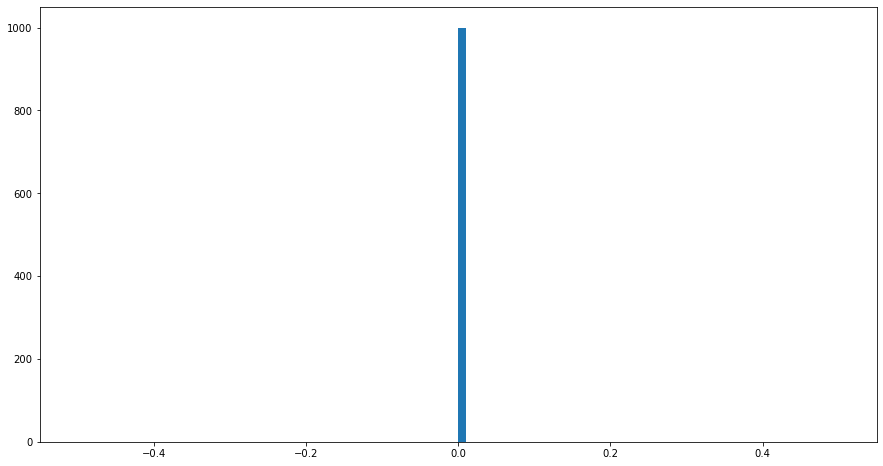

In [197]:
plt.hist(samples[0],bins = 100)
plt.show()

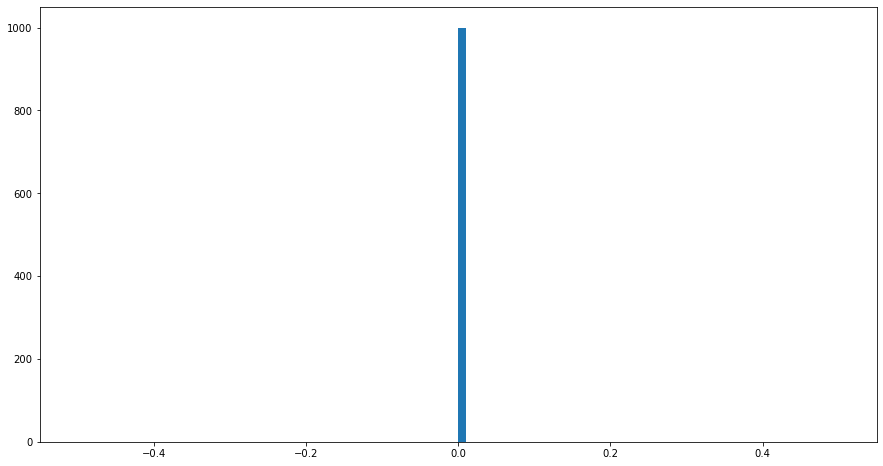

In [198]:
plt.hist(samples[1],bins = 100)
plt.show()

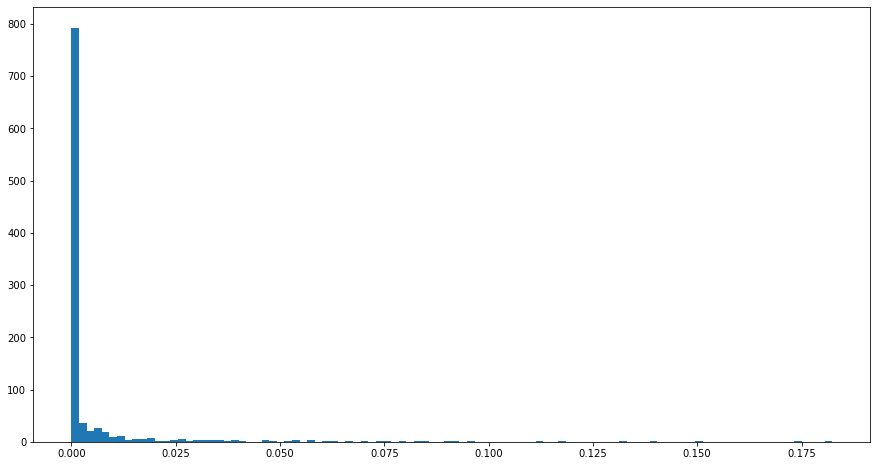

In [199]:
plt.hist(samples[2],bins = 100)
plt.show()

In [200]:
import simple_continuous_buy_sell_spy
env = simple_continuous_buy_sell_spy.simple_continuous_buy_sell_spy()

In [201]:
visualize_time_length = 100

price_history = []
action_history1 = np.zeros((1,visualize_time_length+1))
action_history2 = np.zeros((1,visualize_time_length+1))



price,current_feature = env.reset(return_price=True)
price_history.append(price)


for time_index in range(0,visualize_time_length):

    #compute an action given current observation
    current_feature = np.transpose(current_feature)
    logistic_transform = expit(current_feature)
    holding_position = np.reshape(current_feature[:,-1],(1,1))
    data_point_for_df = np.concatenate((logistic_transform[:,:-1],holding_position),axis = 1)
    assert data_point_for_df.shape[1] == 3
    data_point_for_copula = pd.DataFrame(data_point_for_df)
    action = new_dist.cdf(data_point_for_copula)

    #apply the action to the environment
    price, current_feature,execute_action,need_to_buy,need_to_sell = env.step(action,return_price=True)

    
    #record price and action
    price_history.append(price)
    if execute_action:
        if need_to_buy:
            action_history1[0,time_index+1] = 2
            #print('record buy action')
        if need_to_sell:
            action_history1[0,time_index+1] = 1
            #print('record sell action')

    action_history2[0,time_index+1] = action 
    

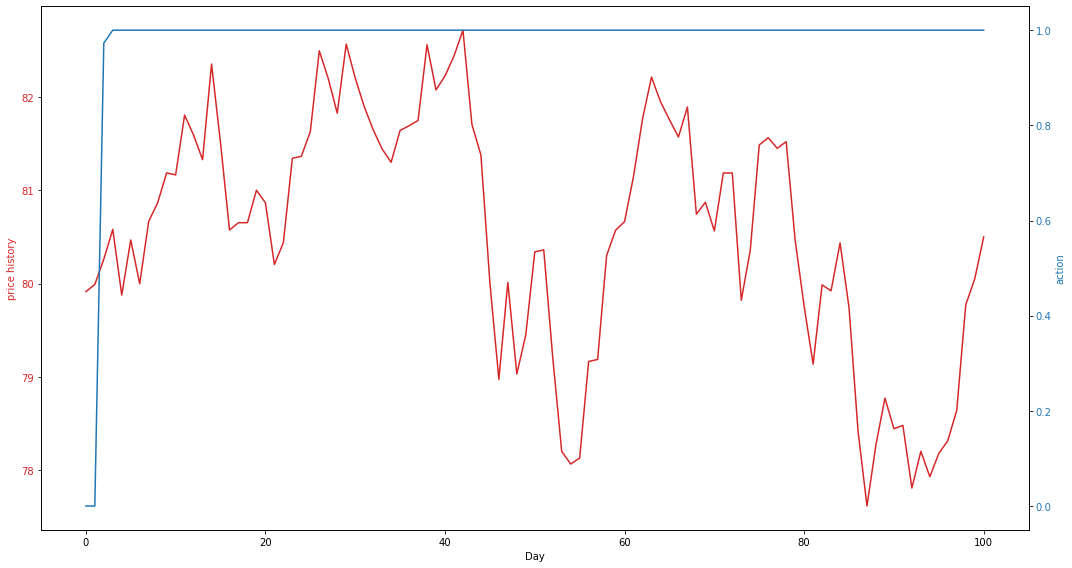

In [202]:
plt.rcParams["figure.figsize"] = (15,8)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('price history', color=color)
ax1.plot(price_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('action', color=color)  # we already handled the x-label with ax1
ax2.plot(action_history2[0,:], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

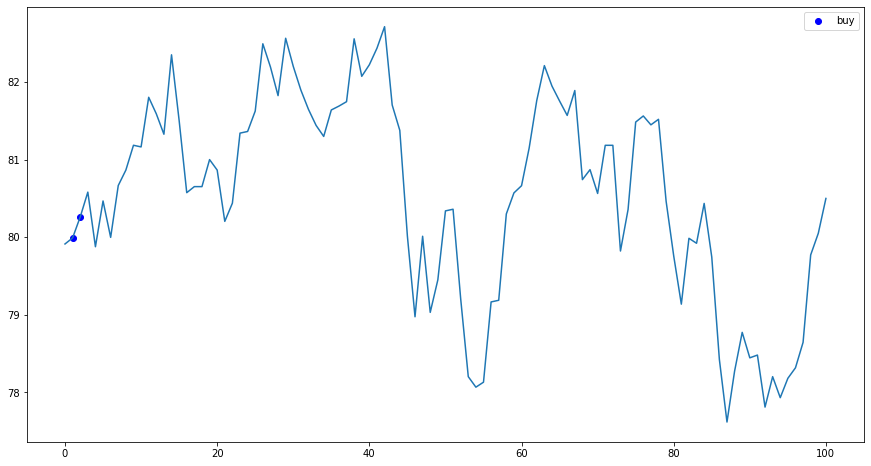

In [203]:
already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(price_history)
for time_index in range(0,len(action_history1[0])):

    if action_history1[0,time_index]==2:
        #print('the buy price is',price_history[time_index])
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,price_history[time_index],color = 'b',label = 'buy')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,price_history[time_index],color = 'b')

    elif action_history1[0,time_index]==1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,price_history[time_index],color = 'r',label = 'sell')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,price_history[time_index],color = 'r')
plt.legend()
plt.show()